# Content:
1. Autocorrect
2. Part of Speech Tagging
3. TBD
4. TBD

In [6]:
# Import
import re                       # regular expression library; for tokenization of words
import matplotlib.pyplot as plt # for data visualization
from collections import Counter, defaultdict # collections library; counter: dict subclass for counting hashable objects
import pandas as pd
import numpy as np
import string
import math
from utils_pos import get_word_tag, preprocess

# Autocorrect

You use *auto-correct* everyday. When you send your friend a text message, or when you make a mistake in a query, there is an autocorrect behind the scenes that corrects the sentence for you. It based on minimum edit distance, which tells you the minimum amount of edits to change one word into another and also it involves dynamic programming methods which is an important programming concept and could be used to solve a lot of optimization problems.

**Autocorrect:**

<u>deah</u> -> dear 

How it works:
1. Identify a misspelled word. (*deah*)
2. Find string n edit distance away. (*_eah d_ar de_r* ... etc)
3. Filter candidates. (*yeah dear dean* ... etc)
4. Calculate probabilities. (how likely each word is to appear in this context)

## Way to identify a word:

Check is a word in the vocabulary or no, if it isn't there it's misspelled.

In [7]:
# if word not in vocabulary:
#    misspelled = True

In [8]:
text = 'red pink pink blue blue yellow ORANGE BLUE BLUE PINK' # 🌈
print(text)
print('string length : ',len(text))

red pink pink blue blue yellow ORANGE BLUE BLUE PINK
string length :  52


In [9]:
# convert all letters to lower case
text_lowercase = text.lower()
print(text_lowercase)
print('string length : ',len(text_lowercase))

red pink pink blue blue yellow orange blue blue pink
string length :  52


In [10]:
# some regex to tokenize the string to words and return them in a list
words = re.findall(r'\w+', text_lowercase)
print(words)
print('count : ',len(words))

['red', 'pink', 'pink', 'blue', 'blue', 'yellow', 'orange', 'blue', 'blue', 'pink']
count :  10


In [11]:
# create vocab
vocab = set(words)
print(vocab)
print('count : ',len(vocab))

{'yellow', 'red', 'blue', 'pink', 'orange'}
count :  5


In [12]:
# create vocab including word count
counts_a = dict()
for w in words:
    counts_a[w] = counts_a.get(w,0)+1
print(counts_a)
print('count : ',len(counts_a))

{'red': 1, 'pink': 3, 'blue': 4, 'yellow': 1, 'orange': 1}
count :  5


In [13]:
# create vocab including word count using collections.Counter
counts_b = dict()
counts_b = Counter(words)
print(counts_b)
print('count : ',len(counts_b))

Counter({'blue': 4, 'pink': 3, 'red': 1, 'yellow': 1, 'orange': 1})
count :  5


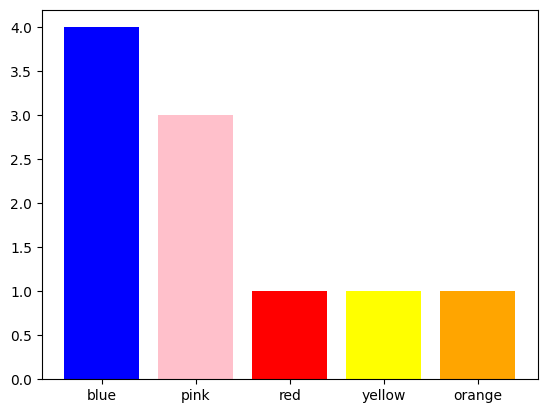

In [14]:
# barchart of sorted word counts
d = {'blue': counts_b['blue'], 'pink': counts_b['pink'], 'red': counts_b['red'], 'yellow': counts_b['yellow'], 'orange': counts_b['orange']}
plt.bar(range(len(d)), list(d.values()), align='center', color=d.keys())
_ = plt.xticks(range(len(d)), list(d.keys()))

## Ways to find a word:
1. Insert (add a letter) *'to': 'two', 'top' ...*
2. Delete (remove a letter) *'hat': 'ha', 'at', 'ht' ...*
3. Switch (swap 2 adjacent letters) *'eta': 'eat', 'tea' ...*
4. Replace (change 1 letter to another): *'jaw': 'jar', 'paw' ...*

In [15]:
# data
word = 'dearz' # 🦌

In [16]:
# Find all the ways you can split a word into 2 parts !
splits_a = []
for i in range(len(word)+1):
    splits_a.append([word[:i],word[i:]])

for i in splits_a:
    print(i)

['', 'dearz']
['d', 'earz']
['de', 'arz']
['dea', 'rz']
['dear', 'z']
['dearz', '']


In [17]:
# Delete a letter from each string in the splits list.
splits = splits_a
deletes = []

print('word : ', word)
for L,R in splits:
    if R:
        print(L + R[1:], ' <-- delete ', R[0])

word :  dearz
earz  <-- delete  d
darz  <-- delete  e
derz  <-- delete  a
deaz  <-- delete  r
dear  <-- delete  z


In [18]:
# It's worth taking a closer look at how this is excecuting a 'delete'.
print('word : ', word)
one_split = splits[0]
print('first item from the splits list : ', one_split)
L = one_split[0]
R = one_split[1]
print('L : ', L)
print('R : ', R)
print('*** now implicit delete by excluding the leading letter ***')
print('L + R[1:] : ',L + R[1:], ' <-- delete ', R[0])

word :  dearz
first item from the splits list :  ['', 'dearz']
L :  
R :  dearz
*** now implicit delete by excluding the leading letter ***
L + R[1:] :  earz  <-- delete  d


In [19]:
deletes = [L + R[1:] for L, R in splits if R]

print(deletes)
print('*** which is the same as ***')
for i in deletes:
    print(i)

['earz', 'darz', 'derz', 'deaz', 'dear']
*** which is the same as ***
earz
darz
derz
deaz
dear


In [20]:
# Next step will be to filter this list for candidate words found in a vocabulary.
vocab = ['dean','deer','dear','fries','and','coke']
edits = list(deletes)

print('vocab : ', vocab)
print('edits : ', edits)

candidates=[]

candidates = set.intersection(set(vocab), set(edits))

print('candidate words : ', candidates)

vocab :  ['dean', 'deer', 'dear', 'fries', 'and', 'coke']
edits :  ['earz', 'darz', 'derz', 'deaz', 'dear']
candidate words :  {'dear'}


## Way to filter candidates:

<u>deah</u> -----> <u>deah</u>

_eah -----> yeah

d_ar -----> dear

de_r -----> dean

...etc -----> ...etc

Minimum edit distance:

Source: play -> Target: stay

D[i,j] = source[:i] -> target[:j]

In [21]:
# COST MATRIX
# # # 0 1 2 3 4
# # # # s t a y
# 0 # 0 1 2 3 4
# 1 p 1 2 3 4 5
# 2 l 2 3 4 5 6
# 3 a 3 4 5 4 5
# 4 y 4 5 6 5 4

# Once you get from p, l to s, d the suffix of both words is the same, a, y. 
# So there are no more edits needed. And that's why this 4 carries down the diagonal. 

# Source: play -> Target: stay
# [0,0] -> (# -> #)
# [1,0] -> (p -> #) delete
# [0,1] -> (# -> s) insert
# [1,1] -> (p -> s) 
#                  insert + delete: p -> ps -> s: 2
#                  delete + insert: p ->  # -> s: 2
#                  replace:         p -> s:       2

# play -> #
# D[i,j] = D[i-1,j] + delete_cost
# D[4,0] = play -> #
#        = source[:4] -> target[0]

# # -> play
# D[i,j] = D[i,j-1] + insert_cost

#### GENERAL ####
# D[i,j] = 
#
#     Г D[i-1,j] + delete_cost
# min | D[i,j-1] + insert_cost
#     L D[i-1,j-1] + Г replace_cost; if source[i] != target[j]
#                    L 0;            if source[i]  = target[j]

### Minimum edit distance
* **Levenshtein distance.** Measuring the edit distance by using the three edits; insert, delete, and replace with costs 1, 1 and 2 respectively. That's what you've used here. 
* **Backtrace.** There are also well-known alternatives that have difference at its rules. Finding the minimum edit distance on its own doesn't always solve the whole problem. You sometimes need to know how you got there too. You do this by keeping a backtrace, which is simply a pointer in each cell letting you know where you came from to get there so you know the path taken across the table from the top left corner to the bottom right corner. This tells you the edits taken and is particularly useful in problems dealing with string alignment. 
* **Dynamic programming.** Finally, this tabular method for computation instead of brute force, is a technique known as dynamic programming. Intuitively, this just means that solving the smallest subproblem first and then reusing that result to solve the next biggest subproblem, saving that result, reusing it again and so on. This is what you did here by solving each cell in order. 

## Way to calculate probabilities:

Probability_of_a_word = (Numbers_of_time_the_word_appears) / (Total_size_of_the_corpus)

In [22]:
senatance= 'Autocorrect is a powerful tool and it is used on our computer.'.split()
print(senatance)
print("P(is) = ", round(senatance.count('is') / len(senatance), 2))

['Autocorrect', 'is', 'a', 'powerful', 'tool', 'and', 'it', 'is', 'used', 'on', 'our', 'computer.']
P(is) =  0.17


# Autocorrect (implementation)

### Process Data

In [23]:
def process_data(file_name):
    """
    Input: 
        A file_name which is found in your current directory. You just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus (text file you read) in lower case. 
    """
    words = []

    # read file and convert into lower case
    with open(file_name, 'r') as text_file:
        raw_text = text_file.read().lower()
    
    # return as a list without special characters
    words = re.findall('\w+', raw_text)
    
    return words

In [24]:
word_l = process_data('D:\Learning_py\kaggle\Autocorrect-and-Autocomplete-NLP\input_data\shakespeare.txt')
vocab = set(word_l)
print(word_l[0:10])

['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']


### Get count of words

In [25]:
def get_count(word_l):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    word_count_dict = {}  # word counts
    
    for word in word_l:
        word_count_dict[word] = word_count_dict.get(word,0) + 1        
    
    return word_count_dict

In [26]:
word_count_dict = get_count(word_l)

### Get probabilities

In [27]:
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs = {} 

    total = sum(word_count_dict.values())
    
    for key, val in word_count_dict.items():
        probs[key] = val / total
    
    return probs

In [28]:
probs = get_probs(word_count_dict)

## String Manipulations

### Delete letter

In [29]:
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_l = []
    split_l = []
    
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    delete_l = [''.join([word[:i], word[(i+1):]]) for i in range(len(word))]
                                                   
    if verbose: print(f"input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

    return  delete_l

In [30]:
delete_word_l = delete_letter(word="citrix", verbose=True)

input word citrix, 
split_l = [('', 'citrix'), ('c', 'itrix'), ('ci', 'trix'), ('cit', 'rix'), ('citr', 'ix'), ('citri', 'x')], 
delete_l = ['itrix', 'ctrix', 'cirix', 'citix', 'citrx', 'citri']


### Switch letter

In [31]:
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    ''' 
    
    switch_l = []
    split_l = []
    
    switch_l = [''.join([word[:i], word[i+1], word[i], word[(i+2):]]) for i in range(len(word)-1)]
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}") 
    
    return switch_l

In [32]:
switch_word_l = switch_letter(word="baeutiful", verbose=True)

Input word = baeutiful 
split_l = [('', 'baeutiful'), ('b', 'aeutiful'), ('ba', 'eutiful'), ('bae', 'utiful'), ('baeu', 'tiful'), ('baeut', 'iful'), ('baeuti', 'ful'), ('baeutif', 'ul'), ('baeutifu', 'l')] 
switch_l = ['abeutiful', 'beautiful', 'bauetiful', 'baetuiful', 'baeuitful', 'baeutfiul', 'baeutiufl', 'baeutiflu']


### Replace letter

In [33]:
def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    replace_l = []
    split_l = []
    
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    
    replace_set = {''.join([word[:word_i], letter, word[(word_i+1):]])
                        for word_i in range(len(word))
                        for letter in letters}
    
    # turn the set back into a list and sort it, for easier viewing
    replace_l = sorted(list(replace_set - {word}))
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")   
    
    return replace_l

In [34]:
replace_l = replace_letter(word='can', verbose=True)

Input word = can 
split_l = [('', 'can'), ('c', 'an'), ('ca', 'n')] 
replace_l ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


### Insert letter

In [35]:
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    insert_l = [''.join([word[:i], letter, word[i:]]) for i in range(len(word)+1) for letter in letters]
    
    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")
    
    return insert_l

In [36]:
insert_l = insert_letter('in', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word in 
split_l = [('', 'in'), ('i', 'n')] 
insert_l = ['ain', 'bin', 'cin', 'din', 'ein', 'fin', 'gin', 'hin', 'iin', 'jin', 'kin', 'lin', 'min', 'nin', 'oin', 'pin', 'qin', 'rin', 'sin', 'tin', 'uin', 'vin', 'win', 'xin', 'yin', 'zin', 'ian', 'ibn', 'icn', 'idn', 'ien', 'ifn', 'ign', 'ihn', 'iin', 'ijn', 'ikn', 'iln', 'imn', 'inn', 'ion', 'ipn', 'iqn', 'irn', 'isn', 'itn', 'iun', 'ivn', 'iwn', 'ixn', 'iyn', 'izn', 'ina', 'inb', 'inc', 'ind', 'ine', 'inf', 'ing', 'inh', 'ini', 'inj', 'ink', 'inl', 'inm', 'inn', 'ino', 'inp', 'inq', 'inr', 'ins', 'int', 'inu', 'inv', 'inw', 'inx', 'iny', 'inz']
Number of strings output by insert_letter('at') is 78


## Combining the Edits

### Edit one letter

In [37]:
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """
    
    edit_one_set = set()
    
    edit_one_set.update(set(delete_letter(word)))
    edit_one_set.update(set(replace_letter(word)))
    edit_one_set.update(set(insert_letter(word)))
    
    if allow_switches:
        edit_one_set.update(set(switch_letter(word)))
        
    return set(edit_one_set)

In [38]:
tmp_word = "of"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word of 
edit_one_l 
['af', 'aof', 'bf', 'bof', 'cf', 'cof', 'df', 'dof', 'ef', 'eof', 'f', 'ff', 'fo', 'fof', 'gf', 'gof', 'hf', 'hof', 'if', 'iof', 'jf', 'jof', 'kf', 'kof', 'lf', 'lof', 'mf', 'mof', 'nf', 'nof', 'o', 'oa', 'oaf', 'ob', 'obf', 'oc', 'ocf', 'od', 'odf', 'oe', 'oef', 'ofa', 'ofb', 'ofc', 'ofd', 'ofe', 'off', 'ofg', 'ofh', 'ofi', 'ofj', 'ofk', 'ofl', 'ofm', 'ofn', 'ofo', 'ofp', 'ofq', 'ofr', 'ofs', 'oft', 'ofu', 'ofv', 'ofw', 'ofx', 'ofy', 'ofz', 'og', 'ogf', 'oh', 'ohf', 'oi', 'oif', 'oj', 'ojf', 'ok', 'okf', 'ol', 'olf', 'om', 'omf', 'on', 'onf', 'oo', 'oof', 'op', 'opf', 'oq', 'oqf', 'or', 'orf', 'os', 'osf', 'ot', 'otf', 'ou', 'ouf', 'ov', 'ovf', 'ow', 'owf', 'ox', 'oxf', 'oy', 'oyf', 'oz', 'ozf', 'pf', 'pof', 'qf', 'qof', 'rf', 'rof', 'sf', 'sof', 'tf', 'tof', 'uf', 'uof', 'vf', 'vof', 'wf', 'wof', 'xf', 'xof', 'yf', 'yof', 'zf', 'zof']

The type of the returned object should be a set <class 'set'>
Number of outputs from edit_one_letter('at') is 129


### Edit Two Letters

In [39]:
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()
    
    words = list(edit_one_letter(word, allow_switches)) 
    for word in words:
        edit_two_set.update(edit_one_letter(word, allow_switches)) 
    
    return edit_two_set

In [40]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


## Suggest Spelling Suggestions

### Get corrections

In [41]:
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    n_best = []
    
    #Step 1: create suggestions as described above    
    if word in vocab:
        suggestions.append(word)
    elif vocab and edit_one_letter(word, allow_switches=True):
        suggestions.extend(edit_one_letter(word, allow_switches=True) & vocab)
    else:
        suggestions.extend(edit_two_letters(word, allow_switches=True) & vocab)
    
    suggestions = set(suggestions)
    
    #Step 2: determine probability of suggestions
    sugg_prob = {i: probs[i] for i in suggestions}
    
    #Step 3: Get all your best words and return the most probable top n_suggested words as n_best
    n_best = list(sorted(sugg_prob.items(), key=lambda x: x[1], reverse=True))[:n]
      
    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [42]:
# Test your implementation 
my_word = 'loe' 
tmp_corrections = get_corrections(my_word, probs, vocab, 2, verbose=True) # keep verbose=True
for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")

# CODE REVIEW COMMENT: using "tmp_corrections" insteads of "cors". "cors" is not defined
print(f"data type of corrections {type(tmp_corrections)}")

entered word =  loe 
suggestions =  {'lo', 'lie', 'love', 'le', 'low', 'lov', 'woe', 'lose'}
word 0: love, probability 0.005204
word 1: lose, probability 0.000541
data type of corrections <class 'list'>


## Minimum Edit Distance

### Dynamic Programming

In [43]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string you are starting with
        target: a string corresponding to the string you want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    # use deletion and insert cost as  1
    m = len(source) 
    n = len(target) 
    #initialize cost matrix with zeros and dimensions (m+1,n+1) 
    D = np.zeros((m+1, n+1), dtype=int) 
      
    # Fill in column 0, from row 1 to row m, both inclusive
    for row in range(1,m+1): # Replace None with the proper range
        D[row,0] = D[row-1,0] + del_cost
        
    # Fill in row 0, for all columns from 1 to n, both inclusive
    for col in range(1,n+1): # Replace None with the proper range
        D[0,col] = D[0, col-1] + ins_cost
        
    # Loop through row 1 to row m, both inclusive
    for row in range(1,m+1):
        
        # Loop through column 1 to column n, both inclusive
        for col in range(1,n+1):
            
            # Intialize r_cost to the 'replace' cost that is passed into this function
            r_cost = rep_cost
            
            # Check to see if source character at the previous row
            # matches the target character at the previous column, 
            if source[row-1] == target[col-1]: # Replace None with a proper comparison
                # Update the replacement cost to 0 if source and target are the same
                r_cost = 0
                
            # Update the cost at row, col based on previous entries in the cost matrix
            # Refer to the equation calculate for D[i,j] (the minimum of three calculated costs)
            D[row,col] = min(
                D[row - 1, col] + del_cost,  # Deletion
                D[row, col - 1] + ins_cost,  # Insertion
                D[row - 1, col - 1] + r_cost  # Replacement
            )
            
    # Set the minimum edit distance with the cost found at row m, column n 
    med = D[m,n]
    
    return D, med

In [44]:
source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


### Minimum Edit Distance with Backtrace

* Edit distance isn’t sufficient 
* * We often need to align each character of the two strings to each other 
* We do this by keeping a “backtrace” Every 'me we enter a cell, remember where we came from 
* When we reach the end, 
* * Trace back the path from the upper right corner to read off the alignment "

In [45]:
def min_edit_distance_backtrace(source, target, ins_cost=1, del_cost=1, rep_cost=2):
    
    m = len(source)
    n = len(target)
    D = np.zeros((m + 1, n + 1), dtype=int)
    operations = [[''] * (n + 1) for _ in range(m + 1)]  # Matrix to store operations

    # Fill in column 0, from row 1 to row m, both inclusive
    for row in range(1, m + 1):
        D[row, 0] = D[row - 1, 0] + del_cost
        operations[row][0] = 'D'

    # Fill in row 0, for all columns from 1 to n, both inclusive
    for col in range(1, n + 1):
        D[0, col] = D[0, col - 1] + ins_cost
        operations[0][col] = 'I'

    # Loop through row 1 to row m, both inclusive
    for row in range(1, m + 1):
        # Loop through column 1 to column n, both inclusive
        for col in range(1, n + 1):
            r_cost = rep_cost if source[row - 1] != target[col - 1] else 0

            if source[row - 1] == target[col - 1]:
                r_cost = 0

            # Update the cost at row, col based on previous entries in the cost matrix
            deletion = D[row - 1, col] + del_cost
            insertion = D[row, col - 1] + ins_cost
            replacement = D[row - 1, col - 1] + r_cost

            D[row, col] = min(deletion, insertion, replacement)

            # Update operations matrix
            if D[row, col] == deletion:
                operations[row][col] = 'D'
            elif D[row, col] == insertion:
                operations[row][col] = 'I'
            else:
                operations[row][col] = 'R' if r_cost != 0 else 'M'

    # Backtrace to get the sequence of operations
    row, col = m, n
    sequence = []

    while row > 0 or col > 0:
        if operations[row][col] == 'D':
            sequence.append(f"Delete '{source[row - 1]}' at position {row}")
            row -= 1
        elif operations[row][col] == 'I':
            sequence.append(f"Insert '{target[col - 1]}' at position {col}")
            col -= 1
        else:
            if operations[row][col] == 'R':
                if source[row - 1] != target[col - 1]:
                    sequence.append(f"Replace '{source[row - 1]}' with '{target[col - 1]}' at position {row}")
            else:
                sequence.append(f"Match '{source[row - 1]}' at position {row}")

            row -= 1
            col -= 1

    sequence.reverse()
    med = D[m, n]

    return D, sequence, med


In [46]:
source =  'play'
target = 'stay'
matrix, sequence, min_edits = min_edit_distance_backtrace(source, target)
print("minimum edits: ", min_edits, "\n")
print(sequence,"\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

["Insert 's' at position 1", "Insert 't' at position 2", "Delete 'p' at position 1", "Delete 'l' at position 2", "Match 'a' at position 3", "Match 'y' at position 4"] 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


# Part of Speech Tagging (POS)

Part of Speech Tagging (POS) is the process of assigning a part of speech to a word. It contains: 

* Markov Chains

* Hidden Markov Models

* Viterbi algorithm

Tag definition [https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html]

In [47]:
# Part of speech tags:
# ------------------------------------------
# LEXICAL TERM    TAG    EXAMPLE
# ------------------------------------------
# noun            NN     something, nothing
# verb            VB     learn, study
# determiner      DT     the, a
# w-adverb        WRB    why, where
# ...             ...    ...
# ------------------------------------------

# Example:
# Why not learn something?
# WRB RB    VB    NN


Part of speech tagging is used for: 

* Identifying named entities

* Speech recognition

* Coreference Resolution

## Working with text files, Creating a Vocabulary and Handling Unknown Words

### Read Text Data

A tagged dataset taken from the Wall Street Journal is provided in the file *WSJ_02-21.pos*.

In [48]:
with open("D:\Learning_py\kaggle\Autocorrect-and-Autocomplete-NLP\input_data\WSJ_02-21.pos", 'r') as f:
    lines = f.readlines()

In [49]:
# Print columns for reference
print("\t\tWord", "\tTag\n")

# Print first five lines of the dataset
for i in range(5):
    print(f'line number {i+1}: {lines[i]}')

		Word 	Tag

line number 1: In	IN

line number 2: an	DT

line number 3: Oct.	NNP

line number 4: 19	CD

line number 5: review	NN



Each line within the dataset has a word followed by its corresponding tag. 

In [50]:
# Print first line (unformatted)
lines[0]

'In\tIN\n'

### Creating a vocabulary

A vocabulary is made up of every word that appeared at least 2 times in the dataset. For this, follow these steps:
* Get only the words from the dataset
* Use a defaultdict to count the number of times each word appears
* Filter the dict to only include words that appeared at least 2 times
* Create a list out of the filtered dict
* Sort the list

In [51]:
words = [word.split("\t")[0] for word in lines]
print(words[:10])

['In', 'an', 'Oct.', '19', 'review', 'of', '``', 'The', 'Misanthrope', "''"]


*defaultdict* are a special kind of dictionaries that return the "zero" value of a type if you try to access a key that does not exist. Since you want the frequencies of words, you should define the defaultdict with a type of int.

In [52]:
# Define defaultdict of type 'int'
freq = defaultdict(int)

# Count frequency of ocurrence for each word in the dataset
for word in words:
    freq[word] += 1

In [53]:
# Create the vocabulary by filtering the 'freq' dictionary; filter out words that appeared only once and also words that are just a newline character
vocab = [k for k, v in freq.items() if (v > 1 and k != '\n')]

In [54]:
# Sort the vocabulary
vocab.sort()

# Print some random values of the vocabulary
print(vocab[2000:2015])

['ARE', 'ARTICLE', 'AS', 'ASCAP', 'ASSETS', 'ASSOCIATION', 'AST', 'AT&T', 'AUS', 'AVX', 'AZT', 'Aaron', 'Ababa', 'Abalkin', 'Abbie']


### Dealing with unknown words

This function will do the following checks and return an appropriate token:

* Check if the unknown word contains any character that is a digit (return *--unk_digit--*)
* Check if the unknown word contains any punctuation character (return *--unk_punct--*)
* Check if the unknown word contains any upper-case character (return *--unk_upper--*)
* Check if the unknown word ends with a suffix that could indicate it is a noun, verb, adjective or adverb (return *--unk_noun--, --unk_verb--, --unk_adj--, --unk_adv--* respectively)
* If a word fails to fall under any condition then its token will be a plain *--unk--*. 

In [55]:
def assign_unk(word):
    """
    Assign tokens to unknown words
    """
    
    # Punctuation characters
    # Try printing them out in a new cell!
    punct = set(string.punctuation)
    
    # Suffixes
    noun_suffix = ["action", "age", "ance", "cy", "dom", "ee", "ence", "er", "hood", "ion", "ism", "ist", "ity", "ling", "ment", "ness", "or", "ry", "scape", "ship", "ty"]
    verb_suffix = ["ate", "ify", "ise", "ize"]
    adj_suffix = ["able", "ese", "ful", "i", "ian", "ible", "ic", "ish", "ive", "less", "ly", "ous"]
    adv_suffix = ["ward", "wards", "wise"]

    # Loop the characters in the word, check if any is a digit
    if any(char.isdigit() for char in word):
        return "--unk_digit--"

    # Loop the characters in the word, check if any is a punctuation character
    elif any(char in punct for char in word):
        return "--unk_punct--"

    # Loop the characters in the word, check if any is an upper case character
    elif any(char.isupper() for char in word):
        return "--unk_upper--"

    # Check if word ends with any noun suffix
    elif any(word.endswith(suffix) for suffix in noun_suffix):
        return "--unk_noun--"

    # Check if word ends with any verb suffix
    elif any(word.endswith(suffix) for suffix in verb_suffix):
        return "--unk_verb--"

    # Check if word ends with any adjective suffix
    elif any(word.endswith(suffix) for suffix in adj_suffix):
        return "--unk_adj--"

    # Check if word ends with any adverb suffix
    elif any(word.endswith(suffix) for suffix in adv_suffix):
        return "--unk_adv--"
    
    # If none of the previous criteria is met, return plain unknown
    return "--unk--"

A POS tagger will always encounter words that are not within the vocabulary that is being used. By augmenting the dataset to include these unknown word tokens you are helping the tagger to have a better idea of the appropriate tag for these words.

### Getting the correct tag for a word

*get_word_tag* function should check if a line is empty and if so, it should return a placeholder word and tag, --n-- and --s-- respectively.

In [56]:
def get_word_tag(line, vocab):
    # If line is empty return placeholders for word and tag
    if not line.split():
        word = "--n--"
        tag = "--s--"
    else:
        # Split line to separate word and tag
        word, tag = line.split()
        # Check if word is not in vocabulary
        if word not in vocab: 
            # Handle unknown word
            tag = assign_unk(word)
    return word, tag

In [57]:
get_word_tag('\n', vocab)

('--n--', '--s--')

In [58]:
get_word_tag('In\tIN\n', vocab)

('In', 'IN')

In [59]:
get_word_tag('tardigrade\tNN\n', vocab)

('tardigrade', '--unk--')

In [60]:
get_word_tag('scrutinize\tVB\n', vocab)

('scrutinize', '--unk_verb--')

### Markov chains 
**Markov chains** is used to identify the probability of the next word. 

For example, you can see that the most likely word after a verb is a noun: 
* Why not learn swimnming? 
* Why not learn swim?

In [61]:
# THE TRANSITION MATRIX
# row - following word,
# column - current word,  
# intersection - probability of following word after current
# initial - begining of the sentance
# ------------------------------------------------------------
#            NN    VB    O
# (initial)  0.4   0.1   0.5
# NN (noun)  0.2   0.2   0.6
# VB (verb)  0.4   0.3   0.3
# O  (other) 0.2   0.3   0.5
# ------------------------------------------------------------

In [62]:
# Define tags for Adverb, Noun and To (the preposition) , respectively
tags = ['RB', 'NN', 'TO']

In [63]:
# Define 'transition_counts' dictionary
transition_counts = {
    ('NN', 'NN'): 16241,
    ('RB', 'RB'): 2263,
    ('TO', 'TO'): 2,
    ('NN', 'TO'): 5256,
    ('RB', 'TO'): 855,
    ('TO', 'NN'): 734,
    ('NN', 'RB'): 2431,
    ('RB', 'NN'): 358,
    ('TO', 'RB'): 200
}

In [64]:
# Store the number of tags in the 'num_tags' variable
num_tags = len(tags)

# Initialize a 3X3 numpy array with zeros
transition_matrix = np.zeros((num_tags, num_tags))

# Print matrix
transition_matrix

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [65]:
# Create sorted version of the tag's list
sorted_tags = sorted(tags)

# Print sorted list
sorted_tags

['NN', 'RB', 'TO']

In [66]:
# Loop rows
for i in range(num_tags):
    # Loop columns
    for j in range(num_tags):
        # Define tag pair
        tag_tuple = (sorted_tags[i], sorted_tags[j])
        # Get frequency from transition_counts dict and assign to (i, j) position in the matrix
        transition_matrix[i, j] = transition_counts.get(tag_tuple)

# Print matrix
transition_matrix

array([[1.6241e+04, 2.4310e+03, 5.2560e+03],
       [3.5800e+02, 2.2630e+03, 8.5500e+02],
       [7.3400e+02, 2.0000e+02, 2.0000e+00]])

In [67]:
# Define 'print_matrix' function;  the matrix can be hard to read as Numpy is more about efficiency, rather than presenting values in a pretty format, for this transform it using a Pandas DataFrame
def print_matrix(matrix):
    print(pd.DataFrame(matrix, index=sorted_tags, columns=sorted_tags))

In [68]:
# Print the 'transition_matrix' by calling the 'print_matrix' function
print_matrix(transition_matrix)

         NN      RB      TO
NN  16241.0  2431.0  5256.0
RB    358.0  2263.0   855.0
TO    734.0   200.0     2.0


In [69]:
# Scale transition matrix
transition_matrix = transition_matrix/10

# Print scaled matrix
print_matrix(transition_matrix)

        NN     RB     TO
NN  1624.1  243.1  525.6
RB    35.8  226.3   85.5
TO    73.4   20.0    0.2


In [70]:
# Compute sum of row for each row
rows_sum = transition_matrix.sum(axis=1,        #  axis=1 refers to the columns so the sum is done by summing each column of a particular row, for each row
                                 keepdims=True) #  the keepdims parameter was set to True so the resulting array had shape (3, 1) rather than (3,)

# Normalize transition matrix
transition_matrix = transition_matrix / rows_sum

# Print sum of rows
transition_matrix

array([[0.67874457, 0.10159646, 0.21965898],
       [0.10299194, 0.65103567, 0.24597238],
       [0.78418803, 0.21367521, 0.00213675]])

In [71]:
# Loop values in the diagonal
for i in range(num_tags):
    transition_matrix[i, i] =  transition_matrix[i, i] + math.log(rows_sum[i])

# Print matrix
print_matrix(transition_matrix)

          NN        RB        TO
NN  8.458964  0.101596  0.219659
RB  0.102992  6.502088  0.245972
TO  0.784188  0.213675  4.541167


C:\Users\maks1\AppData\Local\Temp\ipykernel_6556\1244150798.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  transition_matrix[i, i] =  transition_matrix[i, i] + math.log(rows_sum[i])


### Viterbi Algorithm

The Viterbi algorithm makes use of the transition probabilities and the emission probabilities as follows. 

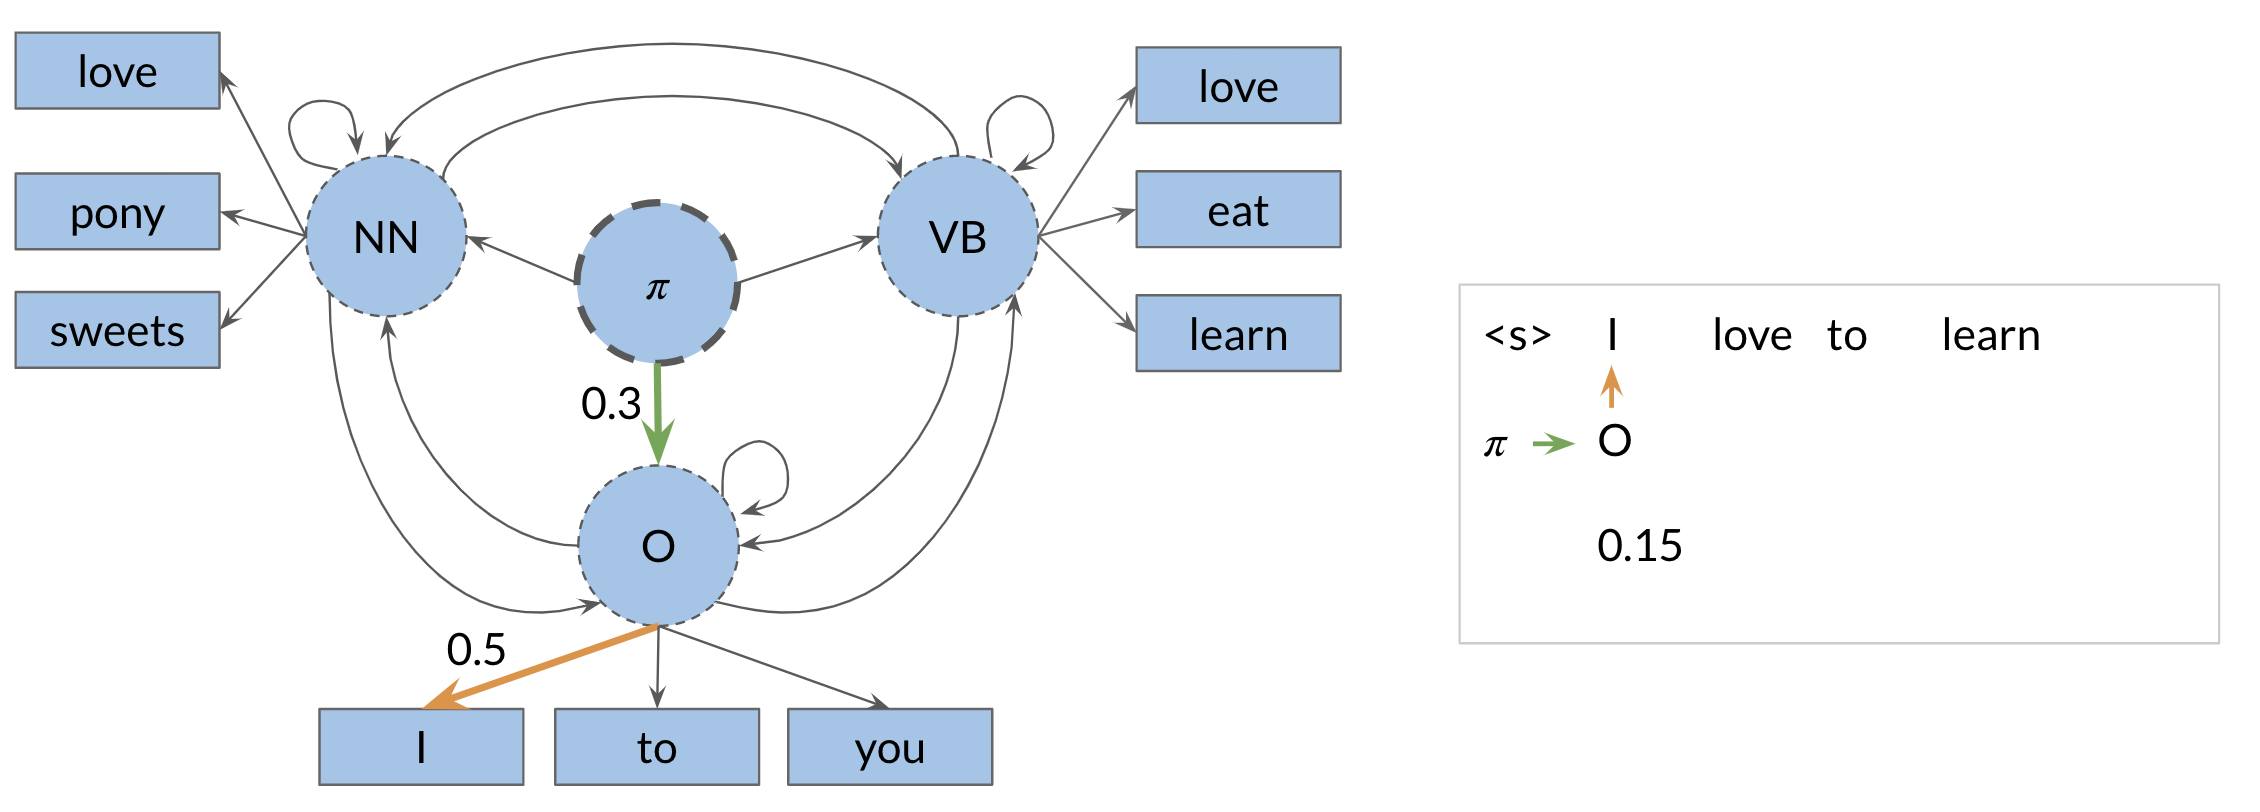

To go from π to O you need to multiply the corresponding transition probability (0.3) and the corresponding emission probability (0.5), which gives you 0.15. You keep doing that for all the words, until you get the probability of an entire sequence. 

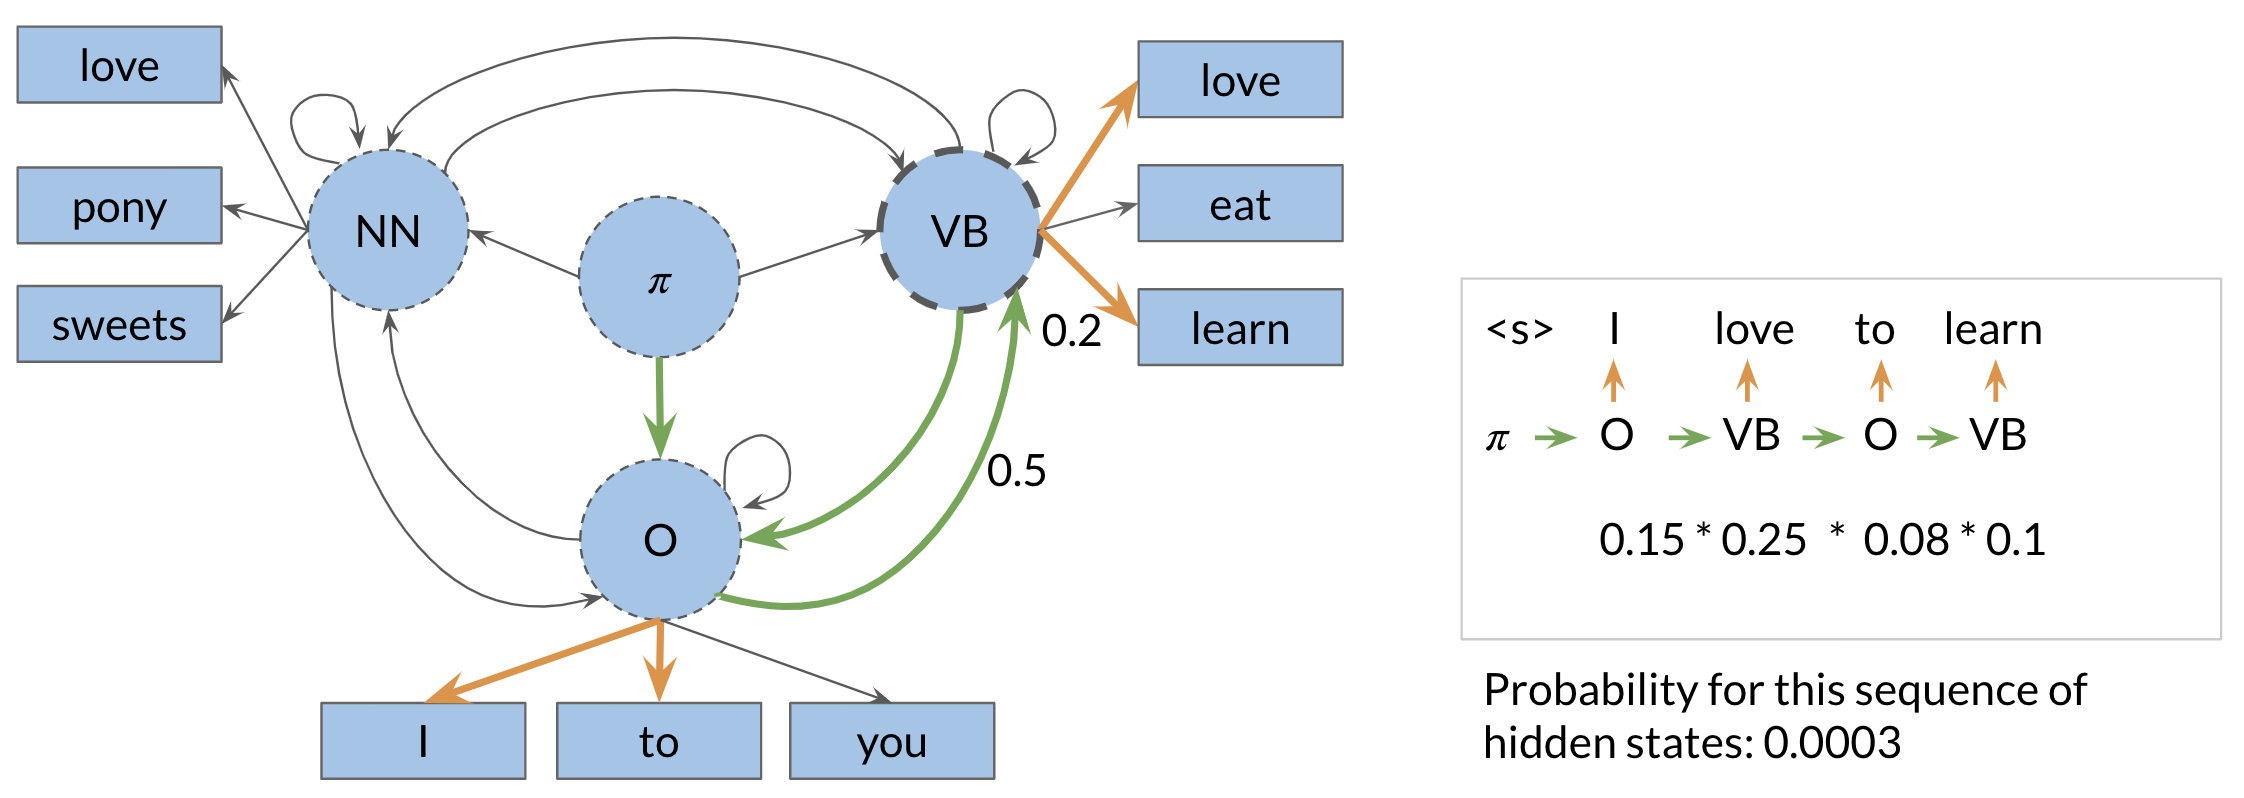

Viterbi Algorithm:
1. Initialization step
2. Forward Pass
3. Backward Pass

# Part of Speech Tagging (implementation)

Tag set: [http://relearn.be/2015/training-common-sense/sources/software/pattern-2.6-critical-fork/docs/html/mbsp-tags.html]

Data:
* (WSJ-2_21.pos) for training.
* (WSJ-24.pos) for testing.
* tagged training data has been preprocessed to form a vocabulary (hmm_vocab.txt)

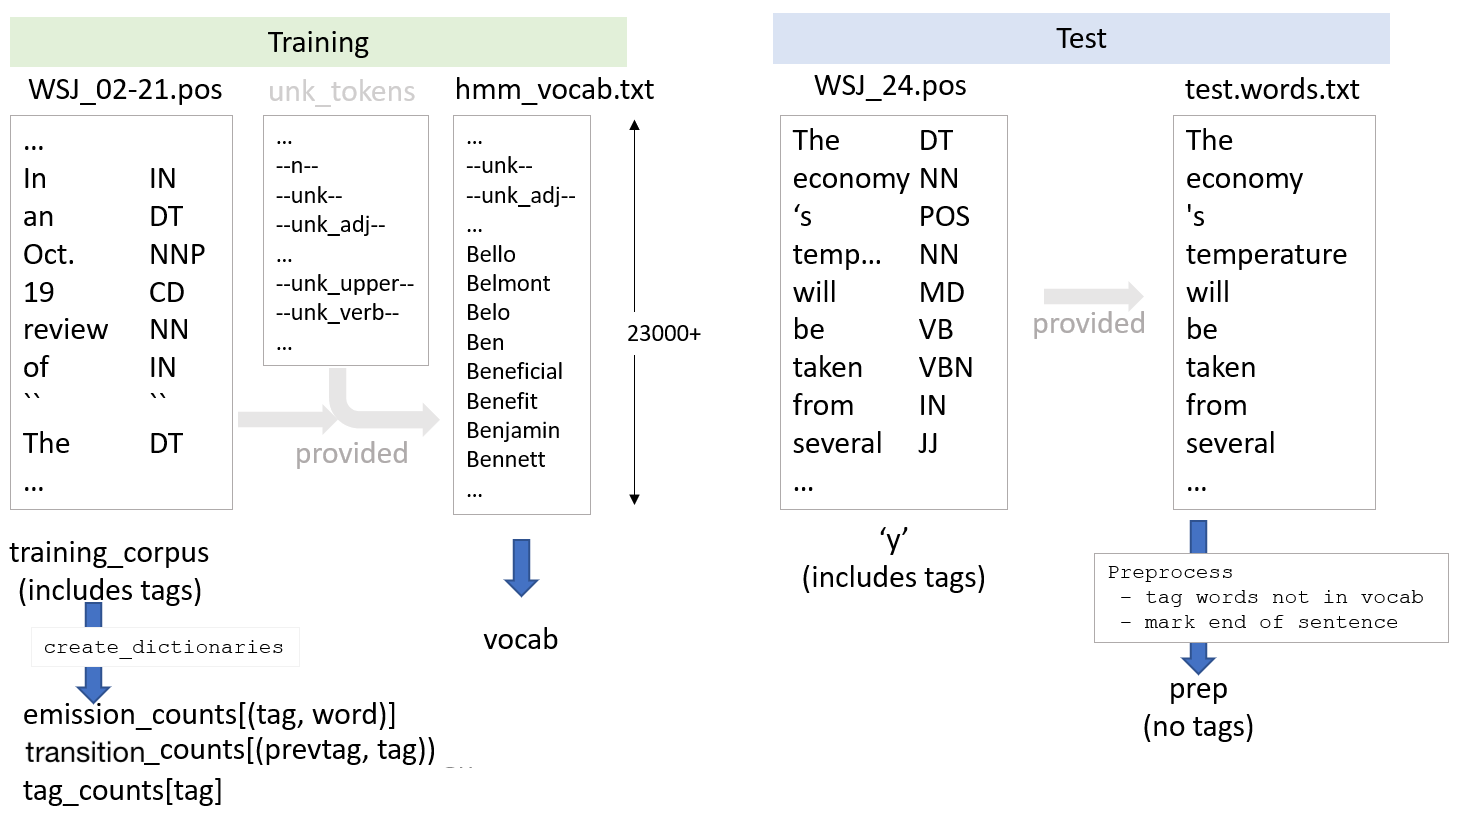

## Data Sources (loading and processing data)

In [72]:
# load in the training corpus
with open("D:\Learning_py\kaggle\Autocorrect-and-Autocomplete-NLP\input_data\WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()

print(f"Training corpus sample")
print(training_corpus[0:5])

Training corpus sample
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [73]:
# read the vocabulary data, split by each line of text, and save the list
with open("D:\Learning_py\kaggle\Autocorrect-and-Autocomplete-NLP\input_data\hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

print("Sample of the begining of the vocabulary list")
print(voc_l[0:50])
print()
print("Sample of the ending of the vocabulary list")
print(voc_l[-50:])

Sample of the begining of the vocabulary list
['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15']

Sample of the ending of the vocabulary list
['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoni

In [74]:
# vocab: dictionary that has the index of the corresponding words
vocab = {}

# Get the index of the corresponding words. 
for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       
    
print("Vocabulary dictionary: key (the word), value (a unique integer)")
count = 0
for k,v in vocab.items():
    print(f"{k}:{v}")
    count += 1
    if count > 10:
        break

Vocabulary dictionary: key (the word), value (a unique integer)
:0
!:1
#:2
$:3
%:4
&:5
':6
'':7
'40s:8
'60s:9
'70s:10


In [75]:
# load in the test corpus
with open("D:\Learning_py\kaggle\Autocorrect-and-Autocomplete-NLP\input_data\WSJ_24.pos", 'r') as f:
    y = f.readlines()
    
print("A sample of the test corpus")
print(y[0:10])

A sample of the test corpus
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [76]:
#corpus without tags, preprocessed
_, prep = preprocess(vocab, r"D:\Learning_py\kaggle\Autocorrect-and-Autocomplete-NLP\input_data\test.words")     

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


## Training

### Create dictionaries:
* *emission_counts*: maps (tag, word) to the number of times it happened.
* *transition_counts*: maps (prev_tag, tag) to the number of times it has appeared.
* *tag_counts*: maps (tag) to the number of times it has occured.

In [77]:
def create_dictionaries(training_corpus, vocab, verbose=True):
    """
    Input: 
        training_corpus: a corpus where each line has a word followed by its tag.
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output: 
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
        tag_counts: a dictionary where the keys are the tags and the values are the counts
    """
    
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 
    
    # use 'i' to track the line number in the corpus
    i = 0 
    
    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:
        
        # Increment the word_tag count
        i += 1
        
        # Every 50,000 words, print the word count
        if i % 50000 == 0 and verbose:
            print(f"word count = {i}")
            
        # get the word and tag using the get_word_tag helper function (imported from utils_pos.py)
        # the function is defined as: get_word_tag(line, vocab)
        word, tag = get_word_tag(word_tag, vocab)
        
        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1
        
        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag
             
    return emission_counts, transition_counts, tag_counts

In [78]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000


In [79]:
# get all the POS states
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 54
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [80]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5042)
(('IN', 'DT'), 32353)
(('DT', 'NNP'), 8721)

emission examples: 
(('VBN', 'stacked'), 3)
(('IN', 'against'), 495)
(('JJ', 'little'), 216)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


### Predict POS
Сomputes the accuracy of your model

In [81]:
def predict_pos(prep, y, emission_counts, vocab, states):
    '''
    Input: 
        prep: a preprocessed version of 'y'. A list with the 'word' component of the tuples.
        y: a corpus composed of a list of tuples where each tuple consists of (word, POS)
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output: 
        accuracy: Number of times you classified a word correctly
    '''
    
    # Initialize the number of correct predictions to zero
    num_correct = 0
    
    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())
    
    # Initialize total count to 0 
    total = 0
    for word, y_tup in zip(prep, y): 

        # Split the (word, POS) string into a list of two items
        y_tup_l = y_tup.split()
        
        # Verify that y_tup contain both word and POS
        if len(y_tup_l) == 2:
            
            # Set the true POS label for this word
            true_label = y_tup_l[1]

        else:
            # If the y_tup didn't contain word and POS, go to next word
            continue
    
        count_final = 0
        pos_final = ''
        
        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:
          
                # define the key as the tuple containing the POS and word
                key = (pos, word)

                # check if the (pos, word) key exists in the emission_counts dictionary
                if key in emission_counts: # Replace None in this line with the proper condition.

                # get the emission count of the (pos,word) tuple 
                    count = emission_counts[key]

                    # keep track of the POS with the largest count
                    if count > count_final: # Replace None in this line with the proper condition.

                        # update the final count (largest count)
                        count_final = count

                        # update the final POS
                        pos_final = pos

            # If the final POS (with the largest count) matches the true POS:
            if pos_final == true_label: # Replace None in this line with the proper condition.
                # Update the number of correct predictions
                num_correct += 1
        # Keep track of the total number of examples (that have valid labels)
        total += 1        

    accuracy = num_correct / total
    
    return accuracy

In [82]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.9013


### Hidden Markov Models for POS
Implementing a Hidden Markov Model (HMM) with a Viterbi decoder

#### Create transition matrix (tag -> tag)

In [ ]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Count the number of unique POS tags
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())
       
    # Go through each row of the transition matrix A
    for i in range(num_tags):
        
        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0
        
            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i], all_tags[j]) # tuple of form (tag,tag)

            # Check if the (prev POS, current POS) tuple 
            # exists in the transition counts dictionary
            if key in trans_keys: # Replace None in this line with the proper condition.
                
                # Get count from the transition_counts dictionary 
                # for the (prev POS, current POS) tuple
                count = transition_counts[key]                

            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]
            
            # Apply smoothing using count of the tuple, alpha, 
            # count of previous tag, alpha, and total number of tags
            A[i,j] = (count + alpha) / (count_prev_tag + alpha*num_tags)

    return A

In [ ]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

#### Create emission matrix (tag -> word)

In [ ]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: a dictionary where keys are words in vocabulary and value is an index.
               within the function it'll be treated as a list
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    
    # get the number of POS tag
    num_tags = len(tag_counts)
    
    # Get a list of all POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)
    
    # Initialize the emission matrix B with places for
    # tags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))
    
    # Get a set of all (POS, word) tuples 
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))
       
    # Go through each row (POS tags)
    for i in range(num_tags): # Replace None in this line with the proper range.
        
        # Go through each column (words)
        for j in range(num_words): # Replace None in this line with the proper range.

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0 
                    
            # Define the (POS tag, word) tuple for this row and column
            key = (all_tags[i], vocab[j]) # tuple of form (tag,word)

            # check if the (POS tag, word) tuple exists as a key in emission counts
            if key in emis_keys: # Replace None in this line with the proper condition.
        
                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts[key]
                
            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]
                
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha) / (count_tag + alpha*num_words)

    return B

In [ ]:
# creating your emission probability matrix. this takes a few minutes to run. 
alpha = 0.001
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

### Viterbi Algorithm and Dynamic Programming

Algorithm which makes use of dynamic programming. Specifically, you will use your two matrices, A (Transitions Matrix) and B (Emissions Matrix) to compute the Viterbi algorithm. We have decomposed this process into three main steps:
* Initialization - In this part you initialize the best_paths and best_probabilities matrices that you will be populating in feed_forward.
* Feed forward - At each step, you calculate the probability of each path happening and the best paths up to that point.
* Feed backward: This allows you to find the best path with the highest probabilities.

#### Initialization

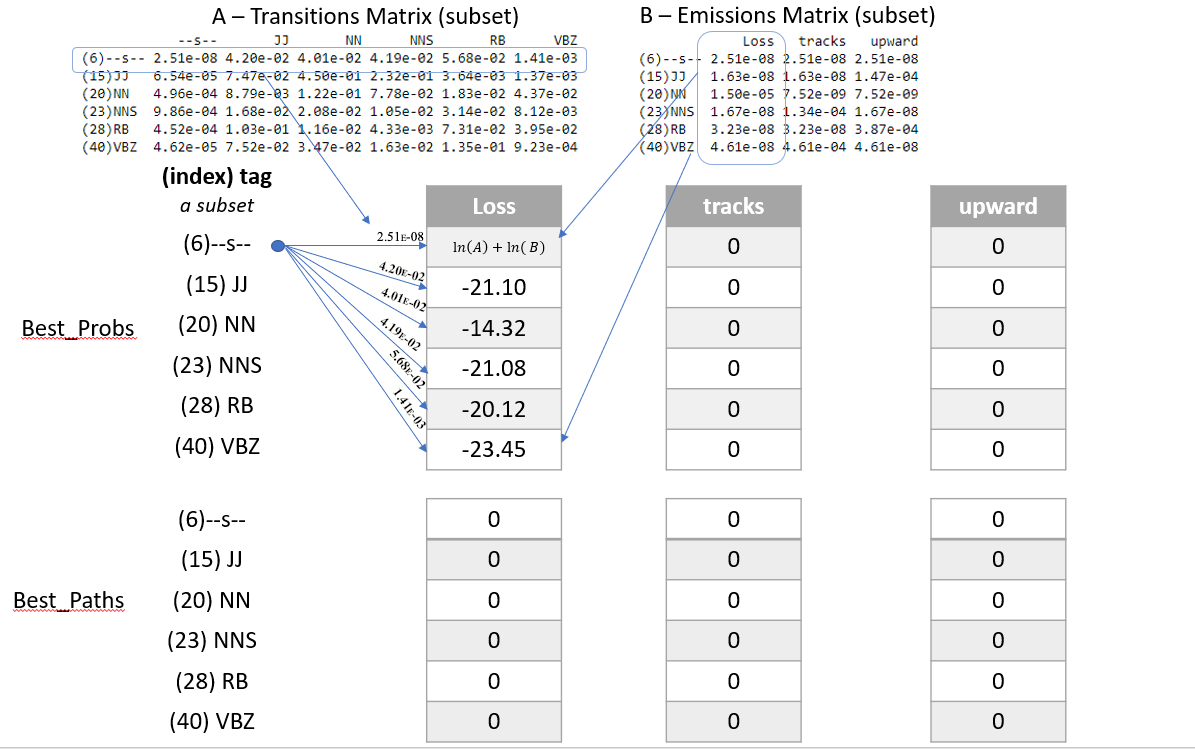

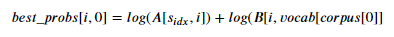

In [ ]:
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: a dictionary where keys are words in vocabulary and value is an index
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    # Get the total number of unique POS tags
    num_tags = len(tag_counts)
    
    # Initialize best_probs matrix 
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))
    
    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    # Define the start token
    s_idx = states.index("--s--")
    
    # Go through each of the POS tags
    for i in range(num_tags): # Replace None in this line with the proper range.
        
        # Initialize best_probs at POS tag 'i', column 0
        # Check the formula in the instructions above
        best_probs[i,0] = np.log(A[s_idx, i]) + np.log(B[i, vocab[corpus[0]]])
            
    return best_probs, best_paths

In [ ]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [ ]:
# Test the function
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}")
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

#### Viterbi Forward

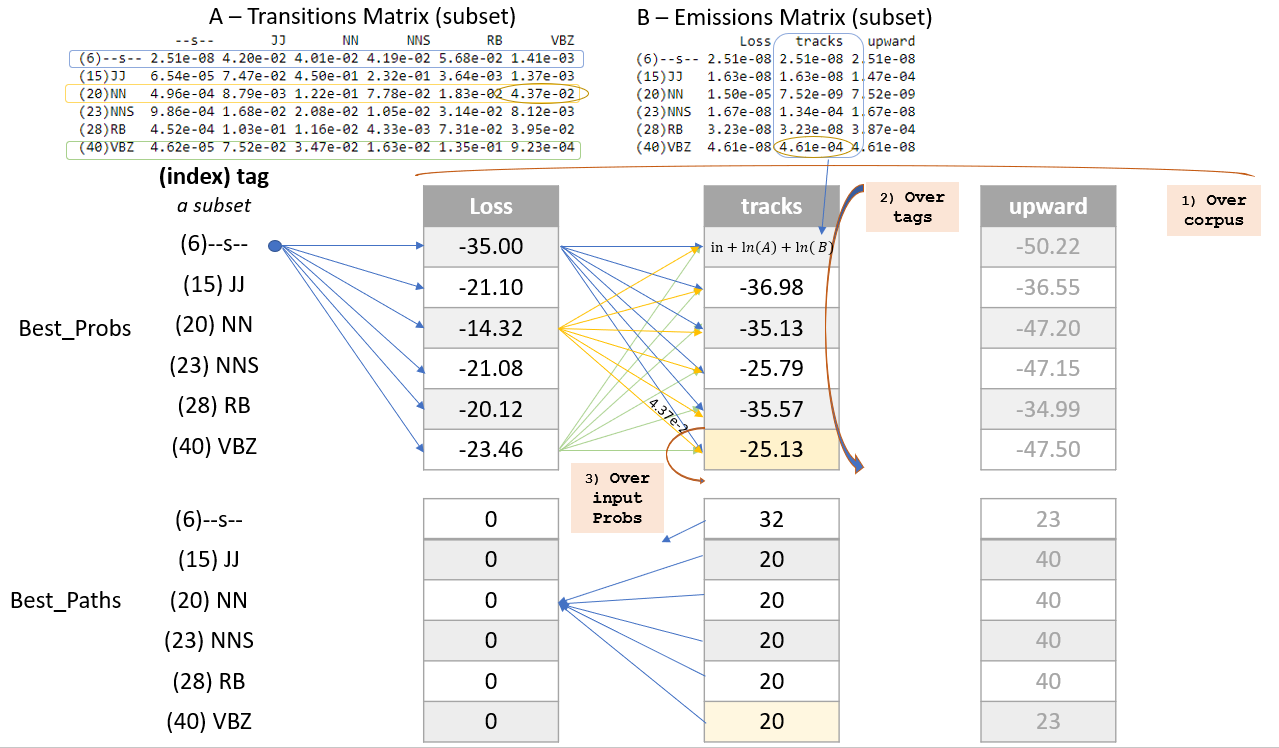

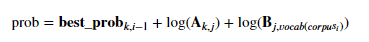

In [ ]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab, verbose=True):
    '''
    Input: 
        A, B: The transition and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a dictionary where keys are words in vocabulary and value is an index 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0 and verbose:
            print("Words processed: {:>8}".format(i))
            
        # For each unique POS tag that the current word can be
        for j in range(num_tags): # Replace None in this line with the proper range. # for every pos tag
            
            # Initialize best_prob for word i to negative infinity
            best_prob_i = float("-inf")
            
            # Initialize best_path for current word i to None
            best_path_i = None # Do not replace this None # @KEEPTHIS

            # For each POS tag that the previous word can be:
            for k in range(num_tags): # Replace None in this line with the proper range.
            
                # Calculate the probability = None
                # best probs of POS tag k, previous word i-1 + 
                # log(prob of transition from POS k to POS j) + 
                # log(prob that emission of POS j is word i)
                prob = best_probs[k,i-1] + np.log(A[k,j]) + np.log(B[j,vocab[test_corpus[i]]])

                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i: # Replace None in this line with the proper condition.
                    
                    # Keep track of the best probability
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word
                    # that is part of the best path.  
                    # Save the index (integer) associated with 
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the 
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

    return best_probs, best_paths

In [ ]:
# this will take a few minutes to run => processes ~ 30,000 words
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

In [ ]:
# Test this function 
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}") 
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}") 

#### Viterbi Backward

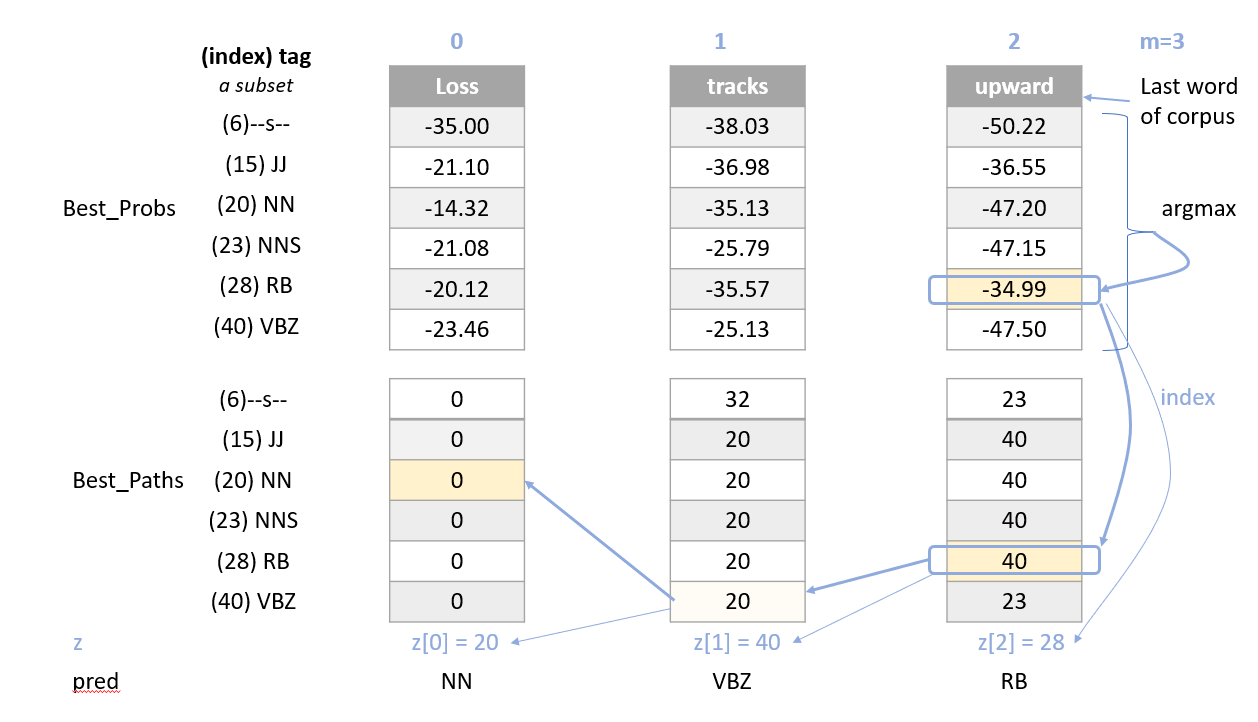

In [ ]:
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m # DO NOT replace the "None"
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m # DO NOT replace the "None"
      
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags): # Replace None in this line with the proper range.

        # If the probability of POS tag at row k 
        # is better than the previously best probability for the last word:
        if best_probs[k, len(corpus)-1] > best_prob_for_last_word: # Replace None in this line with the proper condition.
            
            # Store the new best probability for the last word
            best_prob_for_last_word = best_probs[k, len(corpus)-1]

            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1] = k
            
    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' list
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[z[m - 1]]
    
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(m-1, 0, -1): # Replace None in this line with the proper range.
        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = z[i]
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i, i]
        
        # Get the previous word's POS tag in string form
        # Use the 'states' list, 
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[z[i - 1]]
        
    return pred

In [ ]:
# Run and test your function
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

### Predicting on a Dataset (compute accuracy)

In [ ]:
def compute_accuracy(pred, y):
    '''
    Input: 
        pred: a list of the predicted parts-of-speech 
        y: a list of lines where each word is separated by a '\t' (i.e. word \t tag)
    Output: 
        
    '''
    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        # Split the label into the word and the POS tag
        word_tag_tuple = y.split()
        
        # Check that there is actually a word and a tag
        # no more and no less than 2 items
        if len(word_tag_tuple) != 2: # Replace None in this line with the proper condition.
            continue
        
        # store the word and tag separately
        word, tag = word_tag_tuple[0], word_tag_tuple[1]
        
        # Check if the POS tag label matches the prediction
        if prediction == tag: # Replace None in this line with the proper condition.
            
            # count the number of times that the prediction
            # and label match
            num_correct += 1
            
        # keep track of the total number of examples (that have valid labels)
        total += 1

    return num_correct/total

In [ ]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

In [ ]:
print('The third word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])

# Autocomplete

In [83]:
# TBD